## Installing COBRApy

In [1]:
!pip install cobra -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.8/141.8 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 62.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.1/118.1 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 63.4 MB/s eta 0:00:00


## Loading iML1515 & Creating the Lycopene Producing Model

### Loading the iML1515 Model

In [2]:
import cobra
# Loading the E coli iML1515 Model
model = cobra.io.load_model("iML1515")

Output()

### Adding the Lycopene Pathway Missing Metabolites

In [3]:
from cobra import Metabolite

# Create GGPP (Geranylgeranyl diphosphate)
# FPP (C15) + IPP (C5)
# Formula is C20H33O7P2
ggpp = Metabolite(
    id='ggpp_c',
    formula='C20H33O7P2',
    name='Geranylgeranyl diphosphate',
    compartment='c'
)

# Create Phytoene
# GGPP (C20) + GGPP (C20)
# Formula is C40H64.
phytoene = Metabolite(
    id='phytoene_c',
    formula='C40H64',
    name='Phytoene',
    compartment='c'
)

# Create Lycopene
# Desaturated Phytoene (lost some hydrogen)
# Formula is C40H56
lycopene = Metabolite(
    id='lycopene_c',
    formula='C40H56',
    name='Lycopene',
    compartment='c'
)

# Add the Metabolites to the model
model.add_metabolites([ggpp, phytoene, lycopene])

### Loading the Existing ones

In [4]:
fpp = model.metabolites.get_by_id("frdp_c")  # Farnesyl diphosphate (C15)
ipp = model.metabolites.get_by_id("ipdp_c")  # Isopentenyl diphosphate (C5)
ppi = model.metabolites.get_by_id("ppi_c")   # Pyrophosphate (Byproduct)
q8  = model.metabolites.get_by_id("q8_c")    # Ubiquinone-8 (Oxidized)
q8h2= model.metabolites.get_by_id("q8h2_c")  # Ubiquinol-8 (Reduced)

### Adding the Lycopene Pathway Missing Reactions

In [5]:
from cobra import Reaction

# Reaction 1: GGPP Synthase (CrtE)
# FPP + IPP -> GGPP + PPi
crtE = Reaction('CRTE')
crtE.name = 'GGPP Synthase'
crtE.lower_bound = -1000
crtE.upper_bound = 1000
crtE.add_metabolites({
    fpp: -1,
    ipp: -1,
    ggpp: 1,
    ppi: 1
})

# Reaction 2: Phytoene Synthase (CrtB)
# 2 GGPP -> Phytoene + 2 PPi
crtB = Reaction('CRTB')
crtB.name = 'Phytoene Synthase'
crtB.lower_bound = -1000
crtB.upper_bound = 1000
crtB.add_metabolites({
    ggpp: -2,
    phytoene: 1,
    ppi: 2
})

# Reaction 3: Phytoene Desaturase (CrtI)
# Phytoene + 4 Quinone -> Lycopene + 4 Quinol
crtI = Reaction('CRTI')
crtI.name = 'Phytoene Desaturase'
crtI.lower_bound = 0
crtI.upper_bound = 1000
crtI.add_metabolites({
    phytoene: -1,
    q8: -4,
    lycopene: 1,
    q8h2: 4
})

# Add the Reactions to the model
model.add_reactions([crtE, crtB, crtI])

In [6]:
# Create the demand? Reaction for accumulation/harvesting.

lycopene_demand = model.add_boundary(model.metabolites.get_by_id("lycopene_c"), type="demand")

print(f"Lycopene demand Reaction ID: {lycopene_demand.id}")

Lycopene demand Reaction ID: DM_lycopene_c


### Saving a model xml copy in colab environment

In [7]:
# Setting Lycopene ID & Biomass ID for easy access
biomassID = "BIOMASS_Ec_iML1515_core_75p37M"
lycopeneID = lycopene_demand.id

In [8]:
cobra.io.write_sbml_model(model, "menhed_Ecoli_model.xml")
print("Success! 'menhed_Ecoli_model.xml' has been created.")

Success! 'menhed_Ecoli_model.xml' has been created.


## Calculating the Max Theoritical Yield

In [9]:
with model:
  # Change Objective to Lycopene Producton
  model.objective = lycopeneID

  solution_lyco = model.optimize()
  print(f"Max Lycopene Production: {solution_lyco.objective_value:.4f} mmol/gDW/h")

  biomass_flux = solution_lyco.fluxes[biomassID]
  print(f"Growth Rate during production: {biomass_flux:.4f} 1/h")

Max Lycopene Production: 0.9587 mmol/gDW/h
Growth Rate during production: 0.0000 1/h


## Trying to Achieve Growth Coupling (Old)

### Generating the List of Candidates for Growth Coupling Knockouts

In [ ]:
from cobra.flux_analysis import find_essential_reactions

model.optimize()
# Find Active Reactions
active_reactions = [r.id for r in model.reactions if abs(r.flux) > 1e-5]
print(f"Active Reactions: {len(active_reactions)}")

# Find Essential Reactions
ess_rxns = find_essential_reactions(model)
essential_ids = set(r.id for r in ess_rxns)
print(f"Essential Reactions: {len(essential_ids)}")

# filter to find Active non essential reactions
candidates = [rid for rid in active_reactions if rid not in essential_ids]

# filter again to remove Exchange/Transport reactions
candidates = [rid for rid in candidates if not rid.startswith("EX_") and not rid.endswith("_tpp")]

print(f"Final Candidate Count: {len(candidates)}")

### Brute Force Attempt to do a triple knockout for the selected reactions list - because optknock didnt work for me :'(

In [ ]:
import itertools
from tqdm.notebook import tqdm
import sys

wild_type_growth = model.slim_optimize()

# Check: How many combos will we have to go through?
combos = list(itertools.combinations(candidates, 3)) # Around 608K
print(f"Wild Type Growth: {wild_type_growth:.4f}")
print(f"Testing {len(combos)} combinations...")

results = []

print("STARTING BRUTE FORCE")

for r1, r2, r3 in tqdm(combos):

    # Get reactions
    rxn1 = model.reactions.get_by_id(r1)
    rxn2 = model.reactions.get_by_id(r2)
    rxn3 = model.reactions.get_by_id(r3)

    # Save Old Bounds
    old_bounds_1 = rxn1.bounds
    old_bounds_2 = rxn2.bounds
    old_bounds_3 = rxn3.bounds

    # Apply Knockouts
    rxn1.bounds = (0, 0)
    rxn2.bounds = (0, 0)
    rxn3.bounds = (0, 0)

    # Check Growth
    growth = model.slim_optimize()

    if growth > (0.1 * wild_type_growth):


        # Store original biomass bounds
        bm_rxn = model.reactions.get_by_id(biomassID)
        old_bm_bounds = bm_rxn.bounds

        # Fix growth to 99%
        bm_rxn.bounds = (growth * 0.99, 1000)

        # Swap Objective to MINIMIZE Product
        model.objective = lycopeneID
        model.objective_direction = 'min'

        min_prod = model.slim_optimize(error_value=0.0)

        # Reset Objectives & biomass bounds
        model.objective_direction = 'max'
        model.objective = biomassID
        bm_rxn.bounds = old_bm_bounds

        # Save if Lycopene is produced
        if min_prod > 0.001:
            print(f"MATCH: {r1}, {r2}, {r3} | MinProd: {min_prod:.4f}")
            results.append({
                "Knockouts": (r1, r2, r3),
                "Growth": growth,
                "Min_Product": min_prod
            })

    # Revert Knockouts
    rxn1.bounds = old_bounds_1
    rxn2.bounds = old_bounds_2
    rxn3.bounds = old_bounds_3

print(f"\nFound {len(results)} Coupled Designs!")

# **Strain Models**

## Creating Useful Functions

In [10]:
# Import Needed Things
from cobra.flux_analysis import production_envelope, single_reaction_deletion, single_gene_deletion
import matplotlib.pyplot as plt
import numpy as np
from typing import List, Optional

In [15]:
def plot_production_envelopes(models, production_envelopes: List, normal_growths: Optional[List[float]] = None, growthCutoff: Optional[float] = None, graphLabels: List[str] = None, fixedGrowth: Optional[float] = None, xticks: float = 1.0, yticks: float = 1.0):
  fig, ax = plt.subplots(figsize=(8, 5))
  all_results = []

  # Determine which plotting mode to use for cutoffs and result calculation
  use_fixed_growth_mode = fixedGrowth is not None and fixedGrowth > 0.0
  use_growth_cutoff_mode = growthCutoff is not None and normal_growths is not None

  if use_fixed_growth_mode and use_growth_cutoff_mode:
    print("Warning: Both fixedGrowth and growthCutoff/normal_growths provided. fixedGrowth will take precedence.")
    use_growth_cutoff_mode = False # fixedGrowth takes precedence

  print("="*60)
  for i, (prod_env, label) in enumerate(zip(production_envelopes, graphLabels)):
    ax.plot(prod_env[biomassID],
            prod_env['flux_maximum'], 'o-', label=label)

    if use_fixed_growth_mode:
      targetGrowth = fixedGrowth
      idx = (prod_env[biomassID] - targetGrowth).abs().idxmin()
      production = prod_env.loc[idx, "flux_maximum"]
      print(f"Production for {label} at ~{targetGrowth} growth is ~{production:.4f}")
      all_results.append([targetGrowth, production])

    elif use_growth_cutoff_mode:
      # Ensure normal_growths has enough elements if used
      if i >= len(normal_growths):
          raise IndexError(f"normal_growths list does not have enough elements for label '{label}' at index {i}")
      normal_growth = normal_growths[i]
      targetGrowth = growthCutoff * normal_growth
      idx = (prod_env[biomassID] - targetGrowth).abs().idxmin()
      production = prod_env.loc[idx, "flux_maximum"]
      print(f"Production for {label} at ~{growthCutoff*100}% growth ({targetGrowth:.4f}) is ~{production:.4f}")
      all_results.append([growthCutoff, production])
      ax.axvline(targetGrowth, color=f'C{i}', linestyle='--', alpha=0.7, label=f'{label} {growthCutoff*100}% relative growth')

  print("="*60)

  # Plot a single vertical line after the loop for fixed growth if applicable
  if use_fixed_growth_mode:
    ax.axvline(fixedGrowth, color='red', linestyle='--', alpha=0.7, label=f'{fixedGrowth} Growth Cutoff')

  # Common plotting setup
  ax.set_xlabel('Growth rate (1/h)')
  ax.set_ylabel('Lycopene production')
  ax.set_title('Growth-Production Trade-off')
  ax.grid()
  ax.set_xlim(0, xticks)
  ax.set_ylim(0, yticks)
  ax.set_xticks(np.arange(0, xticks + 0.1, 0.1))
  ax.set_yticks(np.arange(0, yticks + 0.1, 0.1))
  ax.legend()
  plt.tight_layout()
  plt.show()

  return all_results

## Native MEP Pathway + Glucose

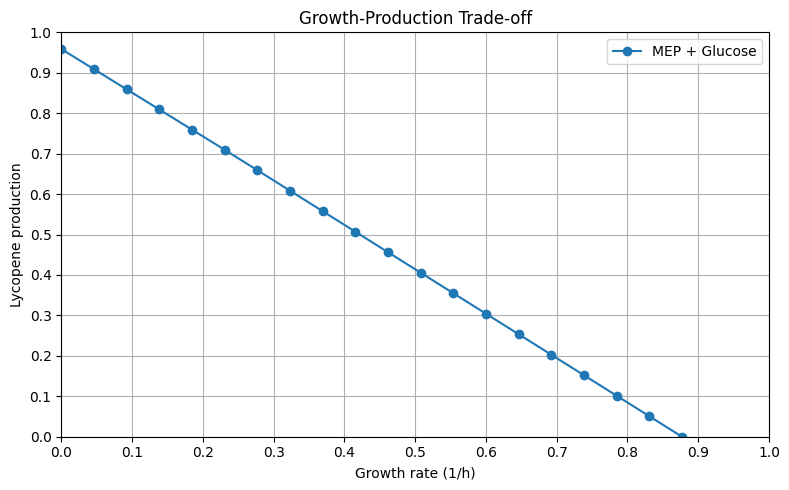

[]

In [19]:
MEP_Glucose_model = model.copy()

# Set carbon source
MEP_Glucose_model.reactions.EX_glc__D_e.lower_bound = -10

# Calculate Normal Growth Rate
MEP_Glucose_model.objective = biomassID
MEP_Glucose_normal_growth = MEP_Glucose_model.optimize().objective_value

MEP_Glucose_Prod_env = production_envelope(
    MEP_Glucose_model,
    [biomassID],
    objective=lycopeneID,
    points=20
)

MEP_Glucose_Label = "MEP + Glucose"

plot_production_envelopes([MEP_Glucose_model], [MEP_Glucose_Prod_env], graphLabels=[MEP_Glucose_Label])

## Native MEP Pathway + Glycerol

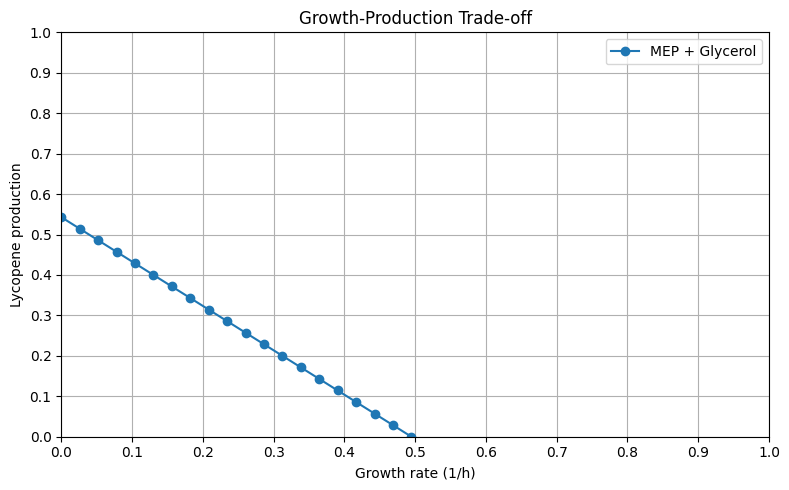

[]

In [20]:
MEP_Glycerol_model = model.copy()

# Set carbon source
MEP_Glycerol_model.reactions.EX_glc__D_e.lower_bound = 0
MEP_Glycerol_model.reactions.EX_glyc_e.lower_bound = -10

# Calculate Normal Growth Rate
MEP_Glycerol_model.objective = biomassID
MEP_Glycerol_normal_growth = MEP_Glycerol_model.optimize().objective_value

MEP_Glycerol_Prod_env = production_envelope(
    MEP_Glycerol_model,
    [biomassID],
    objective=lycopeneID,
    points=20
)

MEP_Glycerol_Label = "MEP + Glycerol"

plot_production_envelopes([MEP_Glycerol_model], [MEP_Glycerol_Prod_env], graphLabels=[MEP_Glycerol_Label])

# **Graph Plotting Section**

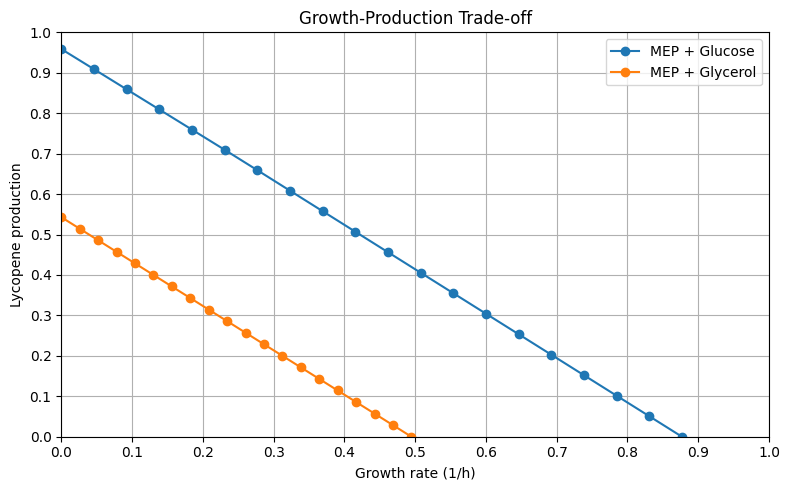

[]

In [21]:
plot_production_envelopes([MEP_Glucose_model, MEP_Glycerol_model],
                          [MEP_Glucose_Prod_env, MEP_Glycerol_Prod_env],
                          graphLabels=[MEP_Glucose_Label, MEP_Glycerol_Label])